In [3]:
import numpy as np
import ast
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
import networkx as nx

from scipy.special import logsumexp

%matplotlib inline
# sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/dev/vivarium-ecoli'))

from ecoli.processes.metabolism_redux_classic import NetworkFlowModel, FlowResult
from ecoli.library.schema import numpy_schema, bulk_name_to_idx, listener_schema, counts
from ecoli.processes.registries import topology_registry
TOPOLOGY = topology_registry.access("ecoli-metabolism-redux")

%matplotlib inline

In [4]:
# create a function to deal with non-homogeous dtype of columns. mixture of strings and lists
def string_to_list(s):
    try:
        return np.array(ast.literal_eval(s))  # Safely convert string to array
    except (ValueError, SyntaxError):
        return np.array(s)  # Return as array if object is not a list and conversion fails (e.g., NaN values)

### Load Experiments

In [5]:
time = '400'
date = '2025-01-13'
experiment = 'metabolism-redux-classic-BASAL_NEW-modified_process_new_rxn_name'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [6]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

### Plot reaction catalyst counts over reaction fluxes for new reactions

/var/folders/bf/9hkc8_c546b6ynkgy9g7hps80000gn/T/ipykernel_52899/4160956839.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 1.1*10**-4])


(3.3575996242986384e-05, 0.00011000000000000002)

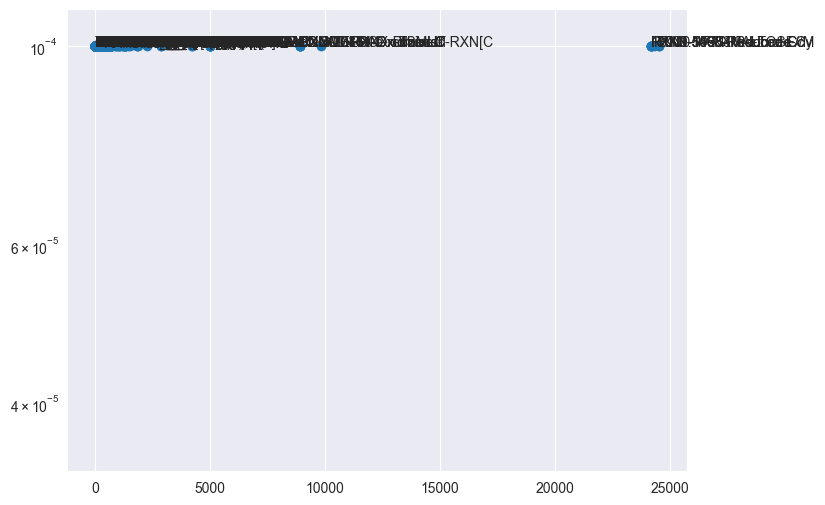

In [8]:
self = agent['ecoli-metabolism-redux-classic']
fba_new_reaction_ids = self.parameters["fba_new_reaction_ids"]
fba_reaction_ids_to_base_reaction_ids = self.parameters['fba_reaction_ids_to_base_reaction_ids']

epi = 1E-4
catalyst_count = np.array(fba['reaction_catalyst_counts'][1:]) # catalyst counts per reaction over time
sim_fluxes     = np.array(fba["estimated_fluxes"][1:]) + epi
reaction_names = self.reaction_names


df_catalyst = pd.DataFrame(catalyst_count, columns = reaction_names)
df_sim_flux = pd.DataFrame(sim_fluxes, columns = reaction_names)

df_catalyst_new = df_catalyst[fba_new_reaction_ids]
df_sim_flux_new = df_sim_flux[fba_new_reaction_ids]

plt.figure(figsize=(8,6))
plt.scatter(df_catalyst_new.mean(axis=0), df_sim_flux_new.mean(axis=0))
plt.yscale('log')
for i, txt in enumerate(df_sim_flux_new.columns):
    plt.annotate(txt[:20], (df_catalyst_new.mean(axis=0)[i], df_sim_flux_new.mean(axis=0)[i]))

plt.ylim([0, 1.1*10**-4])

In [16]:
df_new = pd.DataFrame({'catalyst_count': df_catalyst_new.mean(axis=0), 'sim_flux':df_sim_flux_new.mean(axis=0)})
df_new = df_new.sort_values(by = 'sim_flux', ascending=False)
nonzero_flux = df_new.head(11).index
df_new.head(15)

,catalyst_count,sim_flux
2.7.3.9-RXN,4192.2900,301593.4101
RXN0-313,5.0000,273674.5101
MALSYN-RXN,1796.3900,131272.4826
TRANS-RXN0-574-GLC//GLC.9.,28.0000,127729.5776
ISOCIT-CLEAV-RXN,1426.9025,121052.6801
TRANS-RXN0-574-GLC//Glucopyranose.19.,28.0000,4341.3926
GLUTCYSLIG-RXN,374.7550,2216.8351
GLUCOSAMINE-6-P-DEAMIN-RXN-CPD-13469/WATER//AMMONIUM/FRUCTOSE-6P.38. (reverse),108.2375,948.8801
GLUC1PURIDYLTRANS-RXN,313.2925,470.1826
RXN0-2501,30.2800,197.9001


<p> <span style='background :#fcd1d7' color='black'> There are only 11 new reactions being used. Some of which like 'TRANS-RXN0-574-GLC//Glucopyranose.19.' is considered 'BAD_RXNS' by Cyrus because it seems to give infinite carbon source to e.coli, which are removed in the newest model (haven't ran on that yet) </span> 

### find reactions with high catalyst count by no flux

,catalyst_count,sim_flux
RXN-19953-Reduced-Cys2-Peroxiredoxins/BUTYL-HYDROPEROXIDE//2Cys-Peroxiredoxins-With-HydroxyCys/BUTANOL.93.,24520.5250,0.0001
RXN-19954,24520.5250,0.0001
RXN0-1741-MALTOSE//MALTOSE.17.,24301.5725,0.0001
RXN0-5468,24158.5250,0.0001
RXN0-5468-Reduced-CcmG-Proteins/Cys2-Peroxiredoxin-Disulfide//Oxidized-CcmG-Proteins/Reduced-Cys2-Peroxiredoxins.103.,24158.5250,0.0001
RXN0-5468-Reduced-CcmH-Proteins/Cys2-Peroxiredoxin-Disulfide//Oxidized-CcmH-Proteins/Reduced-Cys2-Peroxiredoxins.103.,24158.5250,0.0001
1.11.1.15-RXN,24158.5250,0.0001
RXN0-5468-Red-thioredoxins-1/Cys2-Peroxiredoxin-Disulfide//Ox-thioredoxins-1/Reduced-Cys2-Peroxiredoxins.95.,24158.5250,0.0001


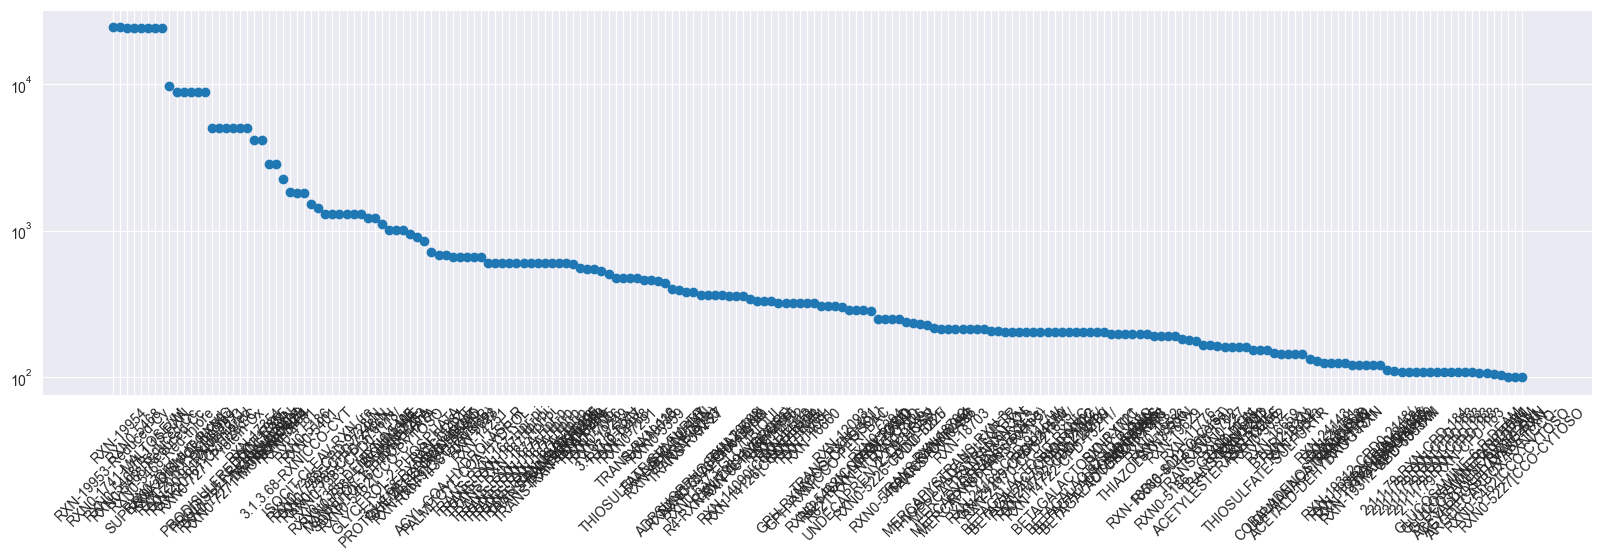

In [82]:
df_no_flux = df_new.iloc[11:,]
df_no_flux = df_no_flux.sort_values(by = 'catalyst_count', ascending=False)

#get df with nonzero catalyst_count
df_no_flux = df_no_flux[df_no_flux.catalyst_count != 0]

# plt.figure(figsize=(20,5))
# plt.plot(df_no_flux.catalyst_count,'o')
# plt.yscale('log')
# plt.xticks(ticks = np.arange(0, len(df_no_flux),1),
#            labels = [txt[:20] for txt in df_no_flux.index], rotation = 45)

# keep around half of the reactions by setting a threshold to 10^2 catalyst counts but no reaction flux
df_high_cat = df_no_flux[df_no_flux.catalyst_count >= 10**2]

plt.figure(figsize=(20,5))
plt.plot(df_high_cat.catalyst_count,'o')
plt.yscale('log')
plt.xticks(ticks = np.arange(0, len(df_high_cat),1),
           labels = [txt[:20] for txt in df_high_cat.index], rotation = 45)
df_high_cat.head(8)

In [1]:
#take the top 8 reactions that have insane catalyst counts and find out what enzyme is contributing to that
top_rxns = df_high_cat.head(8).index
reaction_catalysts = self.parameters["reaction_catalysts"]
catalyst_ids = self.parameters['catalyst_ids']

catalyst_of_interest = np.unique(np.hstack([reaction_catalysts[rxn] for rxn in top_rxns]))
catalyst_of_interest_bulk_idx = bulk_name_to_idx(catalyst_of_interest, self.bulk_ids)

bulk_mean = np.mean(bulk, axis=0)
catalyst_of_interest_counts = counts(bulk_mean, catalyst_of_interest_bulk_idx)
catalyst_of_interest_counts.index = catalyst_of_interest
# print(catalyst_of_interest_counts)


import plotly.graph_objects as go

# sankey plot showing enzyme contribution to each reaction
n_nodes = np.arange(0, len(catalyst_of_interest) + len(top_rxns),1)
labels  = [*catalyst_of_interest, *top_rxns]
label_to_node = {txt:i for i, txt in enumerate(labels)}
color_link = ['#616b4d', '#839868', '#cac093', '#dbb9b3', '#a1bcbe', '#beafa1', '#a3a6bc', '#a3bcab']

source = []
target = []
color  = []
value  = []

for rxn in top_rxns:
    for i, ezm in enumerate(reaction_catalysts[rxn]):
        target.append(label_to_node[ezm])
        source.append(label_to_node[rxn])
        color.append(color_link[label_to_node[ezm]])
        
        rxn_catalysts_count = sum(catalyst_of_interest_counts[reaction_catalysts[rxn]])
        ezm_contribution = catalyst_of_interest_counts[ezm]/rxn_catalysts_count
        value.append(ezm_contribution)



fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 10,
      thickness = 5,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = color,
    ),
    link = dict(
      source = source, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = target,
      value = value,
      color = color, 
  ))])

fig.update_layout(title_text="Top 8 Reactions With High Catalyst Counts But No Flux", font_size=10)
# fig.write_html("../../dev/vivarium-ecoli/notebooks/Heena notebooks/Metabolism_New Genes/out/sankey-rxn-catalyst-contribution-top8.html/")
fig.show() 

# catalyst_of_interest_counts
# # see if the catalysts with high counts are catalyzing other reactions, leading top_rxns no flux
# catalyst_in_other reactions
# for key, value in reaction_catalysts.items():
#     if np.any(np.isin(catalyst_of_interest, value)):
#         
# find out what reactions are the enzymes 

NameError: name 'df_high_cat' is not defined

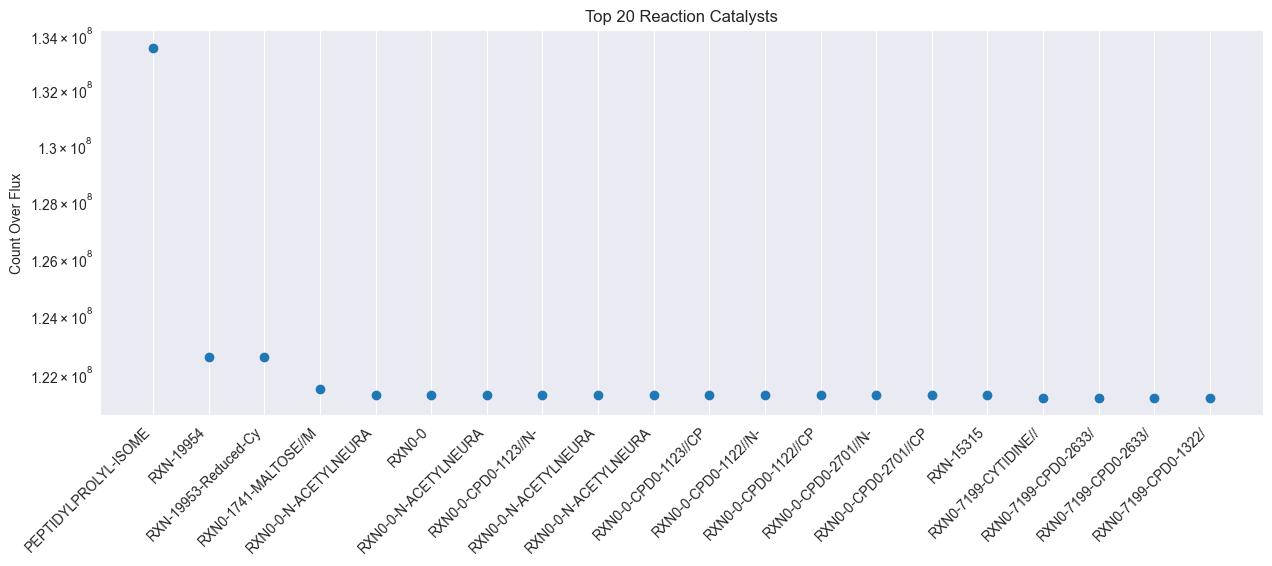

In [19]:

count_over_flux = catalyst_count/(sim_fluxes+epi)
df = pd.DataFrame(count_over_flux, columns = reaction_names)
df_stats = pd.DataFrame({'mean': df.mean(axis = 0), 'std':df.std(axis=0)}).T
df = pd.concat([df,df_stats])
df = df.sort_values(by = 'mean', ascending = False, axis=1)

# shorten all xtick names to 10 characters
plt.figure(figsize=(15, 5))
plt.plot(df.loc['mean'].head(20), 'o')
plt.xticks([i for i in range(20)], [i[:20] for i in df.columns[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Count Over Flux')
plt.title('Top 20 Reaction Catalysts')
plt.show()

In [20]:
reaction_catalysts_dict = self.parameters['reaction_catalysts']
top20_rxn = df.loc['mean'].head(20).index

[reaction_catalysts_dict[rxn] for rxn in top20_rxn]

[['CPLX0-7536[c]',
  'EG10758-MONOMER[c]',
  'EG11003-MONOMER[c]',
  'EG11080-MONOMER[c]',
  'EG12352-MONOMER[c]'],
 ['CPLX0-245[c]', 'CPLX0-7747[c]', 'CPLX0-8157[c]', 'EG10108-MONOMER[c]'],
 ['CPLX0-245[c]', 'CPLX0-7747[c]', 'CPLX0-8157[c]', 'EG10108-MONOMER[c]'],
 ['CPLX0-7530[m]', 'CPLX0-7533[o]', 'CPLX0-7534[o]', 'CPLX0-7655[o]'],
 ['CPLX0-7530[m]', 'CPLX0-7533[o]', 'CPLX0-7534[o]', 'G7921-MONOMER[m]'],
 ['CPLX0-7530[m]', 'CPLX0-7533[o]', 'CPLX0-7534[o]', 'G7921-MONOMER[m]'],
 ['CPLX0-7530[m]', 'CPLX0-7533[o]', 'CPLX0-7534[o]', 'G7921-MONOMER[m]'],
 ['CPLX0-7530[m]', 'CPLX0-7533[o]', 'CPLX0-7534[o]', 'G7921-MONOMER[m]'],
 ['CPLX0-7530[m]', 'CPLX0-7533[o]', 'CPLX0-7534[o]', 'G7921-MONOMER[m]'],
 ['CPLX0-7530[m]', 'CPLX0-7533[o]', 'CPLX0-7534[o]', 'G7921-MONOMER[m]'],
 ['CPLX0-7530[m]', 'CPLX0-7533[o]', 'CPLX0-7534[o]', 'G7921-MONOMER[m]'],
 ['CPLX0-7530[m]', 'CPLX0-7533[o]', 'CPLX0-7534[o]', 'G7921-MONOMER[m]'],
 ['CPLX0-7530[m]', 'CPLX0-7533[o]', 'CPLX0-7534[o]', 'G7921-MONOMER[m]'

### Plot Reaction